# Training and Basic Evaluation for a 2D Binary Classifier

If using MedMNIST for the first time, you will need to install medmnist.

In [1]:
#!pip install medmnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, build_basic_model, argmax_array, generate_training_mixup_images
from plotting_functions import plot_history

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


We set some of our parameters here. The data flag is 'pneumoniamnist' - a binary pneumonia dataset. 

In [3]:
data_flag = 'octmnist'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [4]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz


In [5]:
print(train_dataset)
print(test_dataset)

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: C:\Users\Will Poulett\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset OCTMNIST (octmnist)
    Number of datapoints: 1000
    Root location: C:\Users\Will Poulett\.me

Here we split our data into train, validation, and 2 testing datasets. One is for MUBA, one is for further evaluation. 

In [6]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=4, image_size = 28)

In [7]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 7754, (0, 1, 0, 0): 10213, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


## Basic Model 

This first model we call 'basic' as we are not augmenting the data in any way during training. 

In [8]:
model = build_basic_model(input_shape = (28,28,1), num_classes = 4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./simple_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"simple_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [10]:
history = model.fit(X_train,y_train, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
3047/3047 [==============================] - 75s 24ms/step - loss: 0.4974 - accuracy: 0.8351 - val_loss: 0.9811 - val_accuracy: 0.6955 - lr: 0.0010
Epoch 2/30
   4/3047 [..............................] - ETA: 1:07 - loss: 0.3199 - accuracy: 0.8750

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3047/3047 [==============================] - 78s 26ms/step - loss: 0.3707 - accuracy: 0.8761 - val_loss: 0.4156 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 3/30
3047/3047 [==============================] - 77s 25ms/step - loss: 0.3343 - accuracy: 0.8889 - val_loss: 0.3404 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 4/30
3047/3047 [==============================] - 80s 26ms/step - loss: 0.3138 - accuracy: 0.8964 - val_loss: 0.6248 - val_accuracy: 0.7626 - lr: 0.0010
Epoch 5/30
3047/3047 [==============================] - 80s 26ms/step - loss: 0.2989 - accuracy: 0.9026 - val_loss: 0.2723 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 6/30
3047/3047 [==============================] - 81s 26ms/step - loss: 0.2875 - accuracy: 0.9071 - val_loss: 0.9208 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 7/30
3047/3047 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9103
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
3047/3047 [==============================]

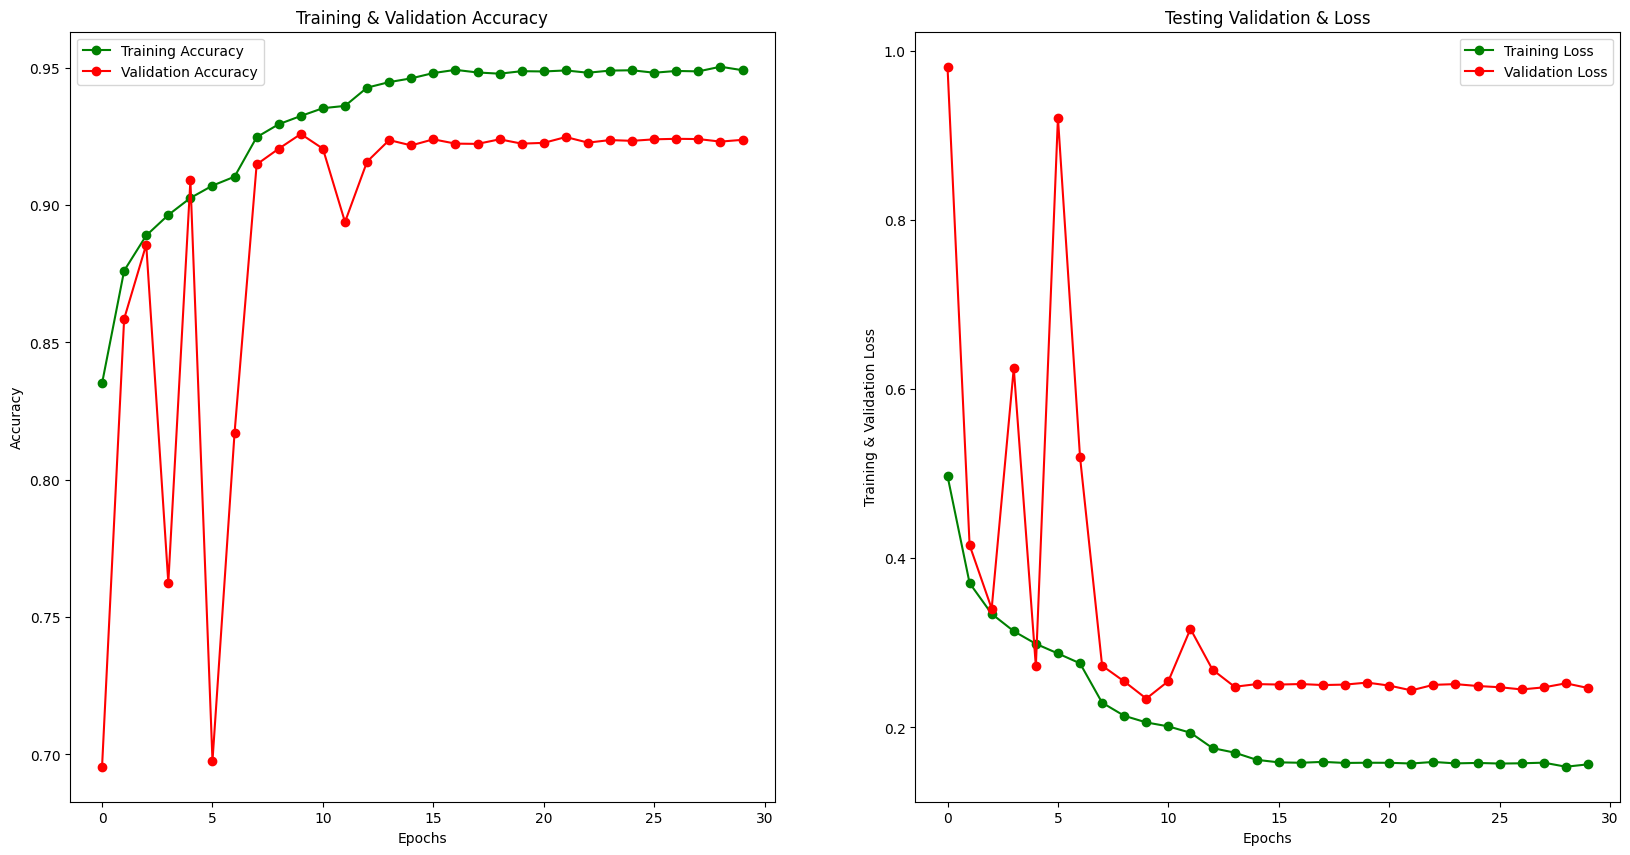

In [11]:
plot_history(history, size=(20,10), epochs = 30)

In [12]:
print(history.history["accuracy"])
print(history.history["loss"])
print(history.history["val_accuracy"])
print(history.history["val_loss"])

[0.8350995779037476, 0.876093864440918, 0.8889173865318298, 0.8963961005210876, 0.9025821685791016, 0.9070755243301392, 0.9103275537490845, 0.9247002005577087, 0.9294295310974121, 0.9324250817298889, 0.9352667927742004, 0.9360977411270142, 0.9427454471588135, 0.9447562098503113, 0.9461308717727661, 0.9480493068695068, 0.9492188096046448, 0.9482647180557251, 0.9478235840797424, 0.9487366080284119, 0.9486340284347534, 0.9490033388137817, 0.948172390460968, 0.9489520788192749, 0.9490649104118347, 0.948172390460968, 0.9488186836242676, 0.9486647844314575, 0.9503574967384338, 0.9490854144096375]
[0.4974197447299957, 0.3706875741481781, 0.33431312441825867, 0.3138120472431183, 0.298885703086853, 0.2874734103679657, 0.2758203148841858, 0.22929295897483826, 0.2138334959745407, 0.20596908032894135, 0.20129241049289703, 0.1937965303659439, 0.17563019692897797, 0.1702844202518463, 0.16174191236495972, 0.1587919294834137, 0.15829084813594818, 0.15934930741786957, 0.15807677805423737, 0.15832756459

In [13]:
best_model = keras.models.load_model("./simple_models/best_model_epoch_10.h5")

In [15]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['choroidal neovascularization','diabetic macular edema','drusen', 'normal']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['choroidal neovascularization','diabetic macular edema','drusen', 'normal']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

22/22 [==============================] - 0s 8ms/step
Test Set A
                              precision    recall  f1-score   support

choroidal neovascularization       0.65      0.97      0.78        79
      diabetic macular edema       0.94      0.81      0.87        80
                      drusen       0.83      0.26      0.40        72
                      normal       0.74      0.96      0.84        69

                    accuracy                           0.76       300
                   macro avg       0.79      0.75      0.72       300
                weighted avg       0.79      0.76      0.73       300


Test Set B
                              precision    recall  f1-score   support

choroidal neovascularization       0.61      0.97      0.75       171
      diabetic macular edema       0.91      0.75      0.83       170
                      drusen       0.94      0.26      0.41       178
                      normal       0.72      0.94      0.82       181

         

## Advanced Model

We call this model 'advanced' as we will use datagen to augment the data each epoch. We use random rotation, width adn height shifts, and horizontal flips. 

In [16]:
model = build_basic_model(input_shape = (28,28,1), num_classes = 4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 14, 14, 64)       

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./advance_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./advance_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [19]:
history_2 = model.fit(datagen.flow(X_train,y_train, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)


Epoch 1/30
3047/3047 [==============================] - 80s 26ms/step - loss: 0.5950 - accuracy: 0.8016 - val_loss: 0.6345 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 2/30
   4/3047 [..............................] - ETA: 1:09 - loss: 0.4367 - accuracy: 0.8828

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3047/3047 [==============================] - 84s 28ms/step - loss: 0.4695 - accuracy: 0.8431 - val_loss: 0.7781 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 3/30
3047/3047 [==============================] - 83s 27ms/step - loss: 0.4347 - accuracy: 0.8547 - val_loss: 0.3935 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 4/30
3047/3047 [==============================] - 88s 29ms/step - loss: 0.4185 - accuracy: 0.8599 - val_loss: 0.4903 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 5/30
3046/3047 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8649
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
3047/3047 [==============================] - 87s 29ms/step - loss: 0.4052 - accuracy: 0.8649 - val_loss: 0.4543 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 6/30
3047/3047 [==============================] - 91s 30ms/step - loss: 0.3670 - accuracy: 0.8770 - val_loss: 0.3506 - val_accuracy: 0.8843 - lr: 3.0000e-04
Epoch 7/30
3047/3047 [===========================

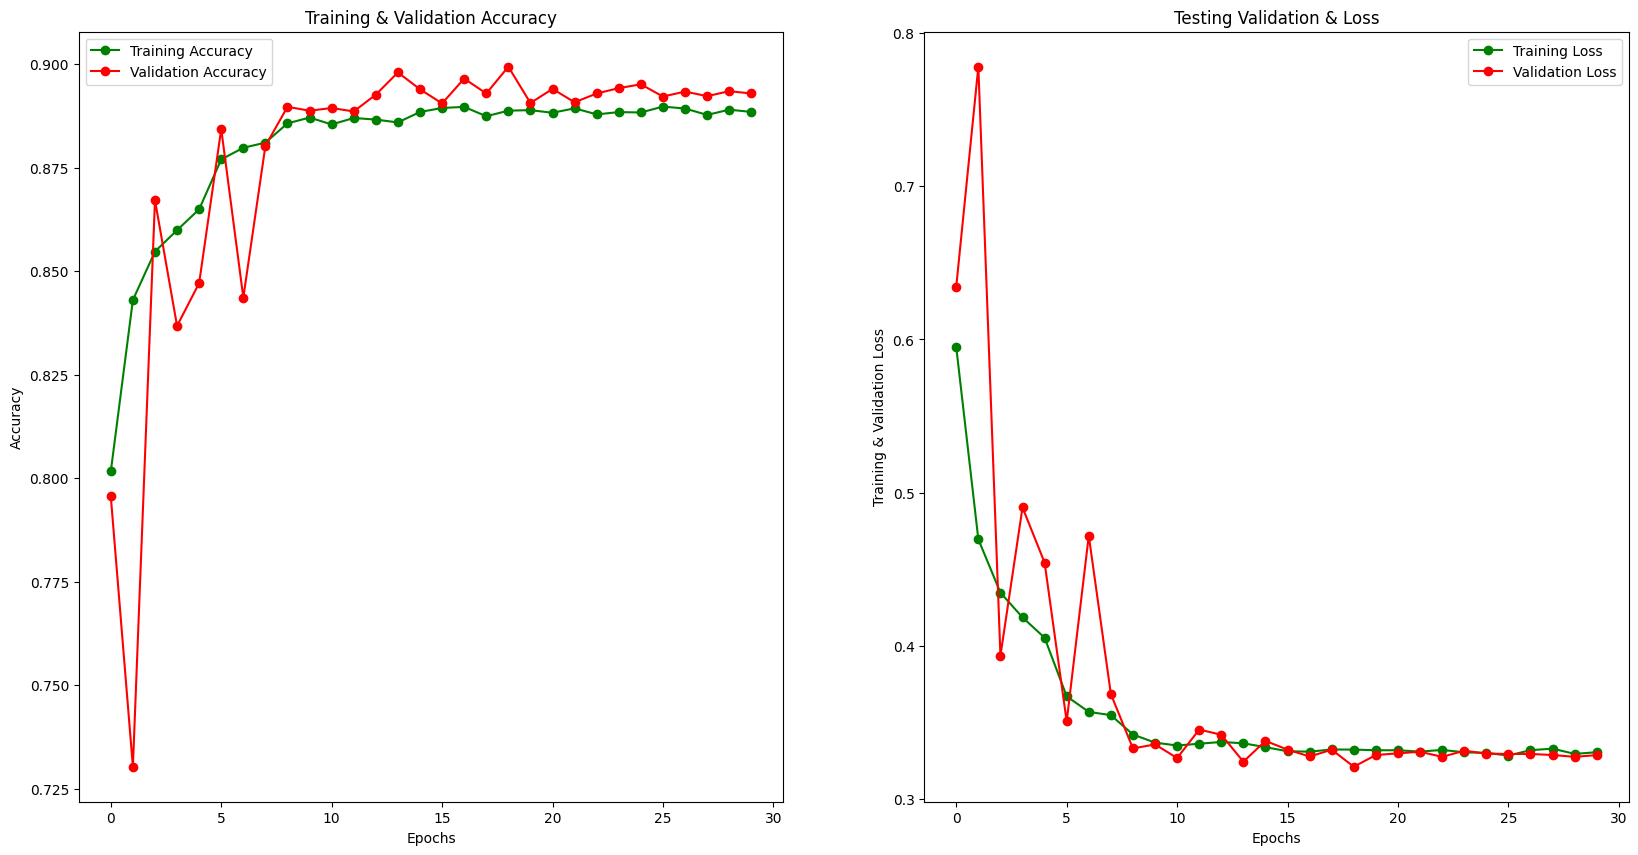

In [20]:
plot_history(history_2, size=(20,10), epochs = 30)

In [21]:
best_model = keras.models.load_model("./advance_models/best_model_epoch_19.h5")

In [23]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['choroidal neovascularization','diabetic macular edema','drusen', 'normal']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['choroidal neovascularization','diabetic macular edema','drusen', 'normal']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

22/22 [==============================] - 0s 9ms/step
Test Set A
                              precision    recall  f1-score   support

choroidal neovascularization       0.76      0.92      0.83        79
      diabetic macular edema       0.84      0.90      0.87        80
                      drusen       0.87      0.28      0.42        72
                      normal       0.69      0.96      0.80        69

                    accuracy                           0.77       300
                   macro avg       0.79      0.76      0.73       300
                weighted avg       0.79      0.77      0.74       300


Test Set B
                              precision    recall  f1-score   support

choroidal neovascularization       0.74      0.94      0.83       171
      diabetic macular edema       0.82      0.90      0.86       170
                      drusen       0.93      0.29      0.44       178
                      normal       0.69      0.93      0.80       181

         

In [24]:
print(history_2.history["accuracy"])
print(history_2.history["loss"])
print(history_2.history["val_accuracy"])
print(history_2.history["val_loss"])

[0.8016455173492432, 0.8430501818656921, 0.8547452092170715, 0.8599054217338562, 0.8649424910545349, 0.876996636390686, 0.8797972798347473, 0.8810386061668396, 0.8856961131095886, 0.887091338634491, 0.8854396343231201, 0.8869886994361877, 0.8866091370582581, 0.885921835899353, 0.8884454965591431, 0.8894097805023193, 0.8896765112876892, 0.8874093294143677, 0.8887634873390198, 0.8888866305351257, 0.8882505893707275, 0.8893277645111084, 0.8878607153892517, 0.8884146809577942, 0.8883223533630371, 0.8897483348846436, 0.8892764449119568, 0.8877376317977905, 0.8889994621276855, 0.8884557485580444]
[0.5949609279632568, 0.4694672226905823, 0.43467003107070923, 0.41851547360420227, 0.40521395206451416, 0.36697423458099365, 0.3568103015422821, 0.35468190908432007, 0.34203654527664185, 0.33673661947250366, 0.33485814929008484, 0.33602625131607056, 0.33716514706611633, 0.336294561624527, 0.33378344774246216, 0.33110520243644714, 0.33084341883659363, 0.332266628742218, 0.33218783140182495, 0.3317626

In [8]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train, y_train)

Text(0.5, 1.0, '[1.93134441e-04 0.00000000e+00 0.00000000e+00 9.99806866e-01]')

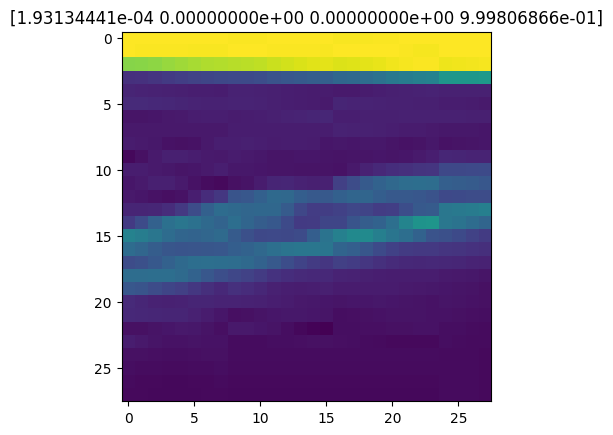

In [19]:
ID = random.randint(0,len(y_train_mixup)-1)
plt.imshow(X_train_mixup[ID])
plt.title(y_train_mixup[ID])

In [20]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, 1)
y_train_mixup = np.array(y_train_mixup)

In [21]:
len(X_train_mixup),len(y_train_mixup)

(97477, 97477)

## Mixup Model

In this model, we use mixup augmentation to train the model. 

In [29]:
model = build_basic_model(input_shape = (28,28,1), num_classes = 4, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_10 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_11 (Ba  (None, 14, 14, 64)       

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./mixup_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./mixup_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [31]:
history_3 = model.fit(X_train_mixup,y_train_mixup, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
3047/3047 [==============================] - 90s 29ms/step - loss: 0.7722 - accuracy: 0.7655 - val_loss: 0.4915 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 2/30
   3/3047 [..............................] - ETA: 1:36 - loss: 0.6532 - accuracy: 0.7917

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3047/3047 [==============================] - 88s 29ms/step - loss: 0.6509 - accuracy: 0.8180 - val_loss: 0.7313 - val_accuracy: 0.7116 - lr: 0.0010
Epoch 3/30
3047/3047 [==============================] - 92s 30ms/step - loss: 0.6185 - accuracy: 0.8323 - val_loss: 0.4121 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 4/30
3047/3047 [==============================] - 89s 29ms/step - loss: 0.5961 - accuracy: 0.8412 - val_loss: 0.8313 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 5/30
3045/3047 [============================>.] - ETA: 0s - loss: 0.5787 - accuracy: 0.8473
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
3047/3047 [==============================] - 93s 30ms/step - loss: 0.5786 - accuracy: 0.8473 - val_loss: 0.5914 - val_accuracy: 0.8063 - lr: 0.0010
Epoch 6/30
3047/3047 [==============================] - 96s 31ms/step - loss: 0.5273 - accuracy: 0.8677 - val_loss: 0.3613 - val_accuracy: 0.9127 - lr: 3.0000e-04
Epoch 7/30
3047/3047 [===========================

In [32]:
best_model = keras.models.load_model("./mixup_models/best_model_epoch_13.h5")

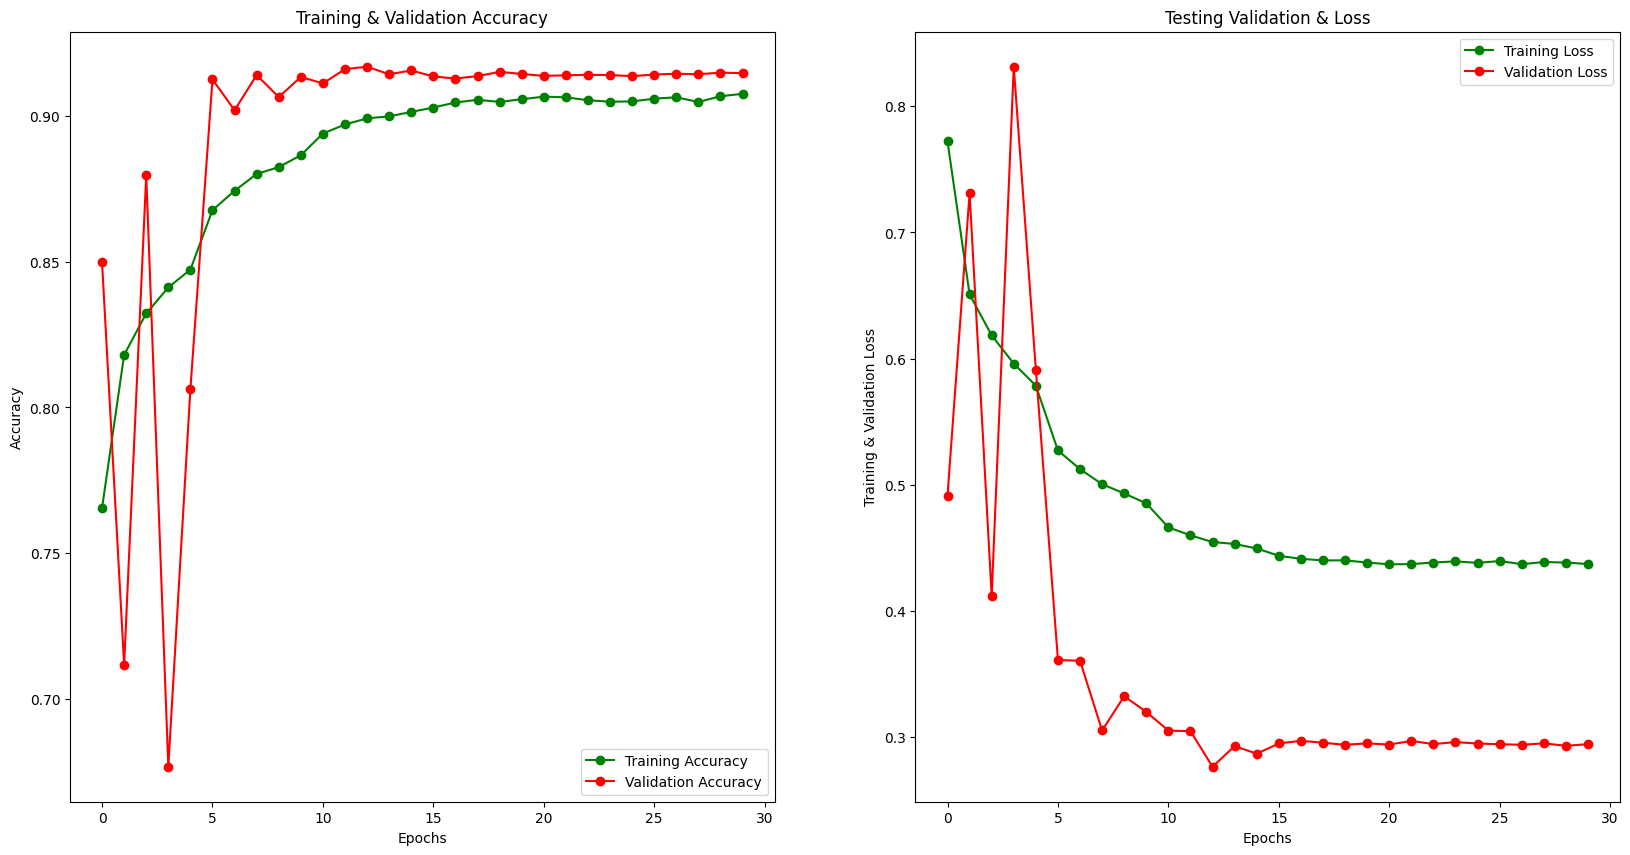

In [33]:
plot_history(history_3, size=(20,10), epochs = 30)

In [35]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['choroidal neovascularization','diabetic macular edema','drusen', 'normal']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['choroidal neovascularization','diabetic macular edema','drusen', 'normal']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

 1/10 [==>...........................] - ETA: 0s

22/22 [==============================] - 0s 8ms/step
Test Set A
                              precision    recall  f1-score   support

choroidal neovascularization       0.67      0.96      0.79        79
      diabetic macular edema       0.95      0.76      0.85        80
                      drusen       0.86      0.35      0.50        72
                      normal       0.71      0.96      0.81        69

                    accuracy                           0.76       300
                   macro avg       0.80      0.76      0.74       300
                weighted avg       0.80      0.76      0.74       300


Test Set B
                              precision    recall  f1-score   support

choroidal neovascularization       0.65      0.96      0.77       171
      diabetic macular edema       0.91      0.81      0.86       170
                      drusen       0.89      0.33      0.48       178
                      normal       0.74      0.94      0.83       181

         

## Oversampling

In [36]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 7754, (0, 1, 0, 0): 10213, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


In [ ]:
# Will increase diabetic macular edema 4x
# Will increase drusen 5x

In [39]:
X_train_oversample = []
y_train_oversample = []

for X, y in zip(X_train,y_train):
    if y[1] == 1: 
        for i in range(4):
            X_train_oversample.append(X)
            y_train_oversample.append(y)
    elif y[2] == 1:
        for i in range(5):
            X_train_oversample.append(X)
            y_train_oversample.append(y)
    else:
        X_train_oversample.append(X)
        y_train_oversample.append(y)

X_train_oversample = np.array(X_train_oversample).reshape(-1, image_size, image_size, 1)
y_train_oversample = np.array(y_train_oversample)

In [47]:
get_label_counts(y_train_oversample,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 38770, (0, 1, 0, 0): 40852, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


In [41]:
model = build_basic_model(input_shape = (28,28,1), num_classes = 4, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 14, 14, 64)       

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [43]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_oversample)

In [44]:
history_4 = model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
4973/4973 [==============================] - 150s 30ms/step - loss: 0.8411 - accuracy: 0.6543 - val_loss: 0.5580 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 2/30
   3/4973 [..............................] - ETA: 2:25 - loss: 0.6724 - accuracy: 0.7396

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4973/4973 [==============================] - 157s 32ms/step - loss: 0.6752 - accuracy: 0.7328 - val_loss: 0.8085 - val_accuracy: 0.6072 - lr: 0.0010
Epoch 3/30
4972/4973 [============================>.] - ETA: 0s - loss: 0.6327 - accuracy: 0.7507
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
4973/4973 [==============================] - 168s 34ms/step - loss: 0.6327 - accuracy: 0.7507 - val_loss: 0.6831 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 4/30
4973/4973 [==============================] - 173s 35ms/step - loss: 0.5647 - accuracy: 0.7791 - val_loss: 0.5007 - val_accuracy: 0.8181 - lr: 3.0000e-04
Epoch 5/30
4973/4973 [==============================] - 168s 34ms/step - loss: 0.5500 - accuracy: 0.7857 - val_loss: 0.5294 - val_accuracy: 0.8070 - lr: 3.0000e-04
Epoch 6/30
4973/4973 [==============================] - 157s 31ms/step - loss: 0.5427 - accuracy: 0.7894 - val_loss: 0.4644 - val_accuracy: 0.8334 - lr: 3.0000e-04
Epoch 7/30
4973/4973 [==============

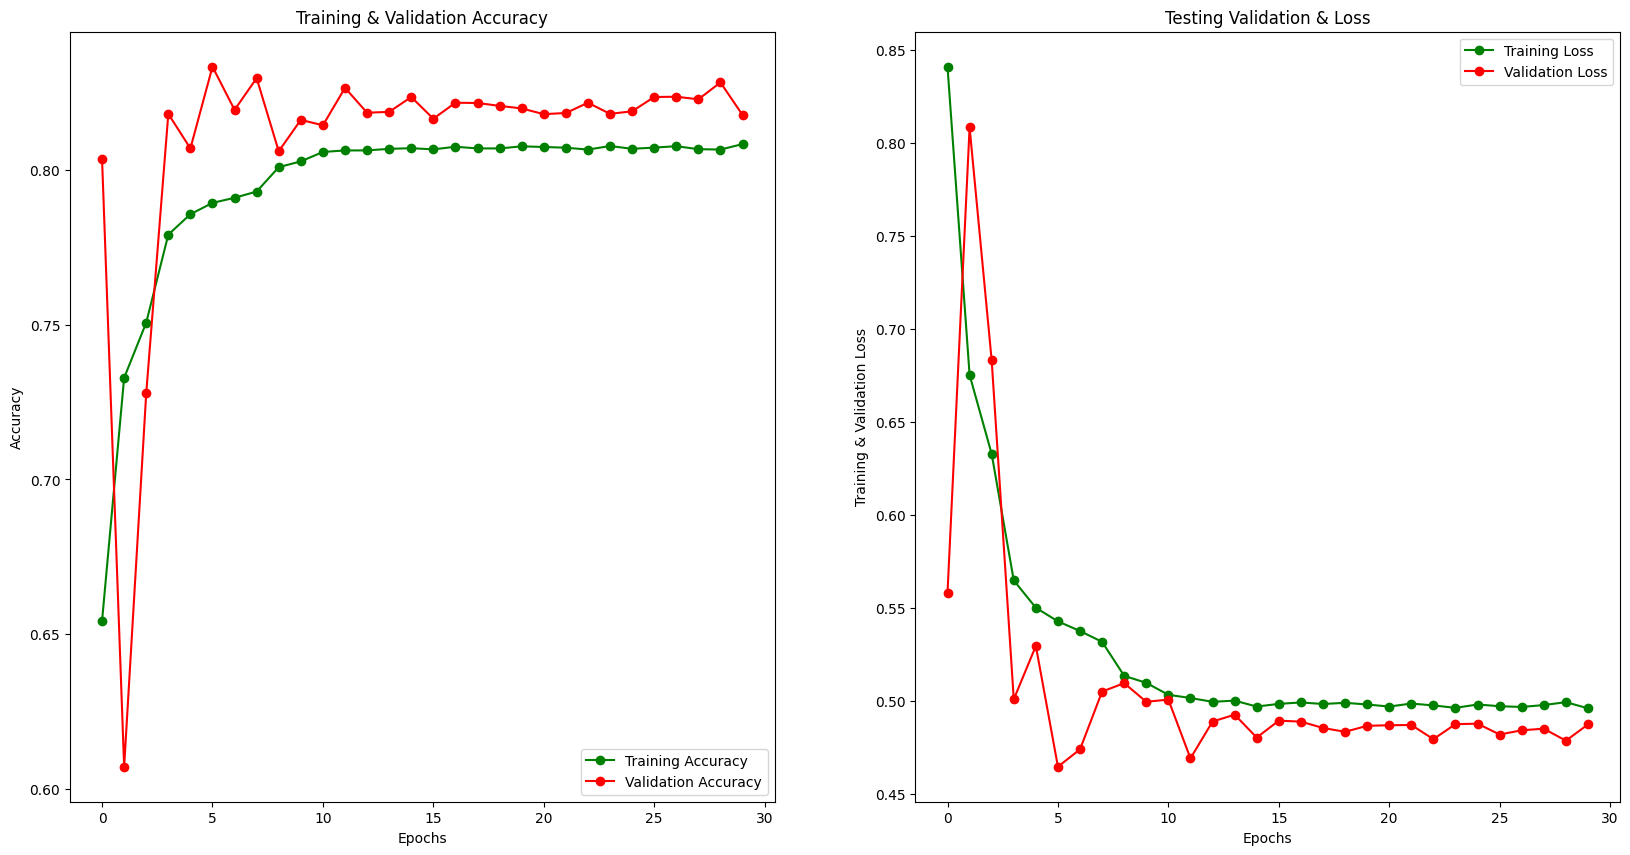

In [45]:
plot_history(history_4, size=(20,10), epochs = 30)

In [46]:
best_model = keras.models.load_model("./oversample_models/best_model_epoch_06.h5")

In [48]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

22/22 [==============================] - 0s 9ms/step
Test Set A
                              precision    recall  f1-score   support

choroidal neovascularization       0.85      0.91      0.88        79
      diabetic macular edema       0.83      0.93      0.88        80
                      drusen       0.90      0.60      0.72        72
                      normal       0.79      0.90      0.84        69

                    accuracy                           0.84       300
                   macro avg       0.84      0.83      0.83       300
                weighted avg       0.84      0.84      0.83       300


Test Set B
                              precision    recall  f1-score   support

choroidal neovascularization       0.82      0.90      0.86       171
      diabetic macular edema       0.83      0.94      0.88       170
                      drusen       0.86      0.55      0.67       178
                      normal       0.77      0.88      0.82       181

         